In [25]:
import netCDF4 as nc  # For reading NetCDF files
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting
import cartopy.crs as ccrs  # For map projections (if needed)
import datetime  # For handling date and time
import os  # For file and directory operations
import torch  # For PyTorch
import torch.nn as nn  # For neural networks
from moviepy.editor import ImageSequenceClip  # For video creation
from sklearn.metrics import mean_squared_error  # For evaluating the model
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms  # <-- Add this import
from PIL import Image
import os

In [29]:

# Image Preprocessing

# Image Preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images if needed
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images for RGB
])

# Path to the folder where your images are stored
output_dir = "D:/first_project_smart_meteorology/pictures"

# Generate list of image file paths
image_filepaths = [os.path.join(output_dir, f) for f in sorted(os.listdir(output_dir)) if f.endswith('.png')]

# Load images
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths) - 1  # Exclude the last image for target

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Convert to RGB
        if self.transform:
            image = self.transform(image)

        # Get the next image as the target
        target_path = self.image_paths[idx + 1]
        target = Image.open(target_path).convert("RGB")  # Convert to RGB
        if self.transform:
            target = self.transform(target)

        return image, target  # Return both image and target

image_filepaths = sorted(image_filepaths)  # Make sure images are in time order
dataset = CustomDataset(image_filepaths, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 1)  # Output a single scalar for forecasting

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize Model, Loss, and Optimizer
model = CNN()
criterion = nn.MSELoss()  # For forecasting
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for images, targets in dataloader:  # Get both images and targets
        optimizer.zero_grad()
        outputs = model(images)  # Model output
        # Assume targets are a certain feature you want to forecast, e.g., average pixel value
        targets = targets.mean(dim=(1, 2, 3))  # Example: reduce targets to a single scalar
        loss = criterion(outputs.view(-1), targets)  # Reshape outputs for comparison
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}')

print('Training Complete.')

Epoch 1, Loss: 0.5862395324123403
Epoch 2, Loss: 0.046595679252883805
Epoch 3, Loss: 0.013604190549813211
Epoch 4, Loss: 0.002566482483719786
Epoch 5, Loss: 0.0007864047117133547
Epoch 6, Loss: 0.0003132915473239943
Epoch 7, Loss: 0.00016668622144303905
Epoch 8, Loss: 0.00011253562843194231
Epoch 9, Loss: 7.047147725340135e-05
Epoch 10, Loss: 4.304956049357619e-05
Training Complete.


In [36]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets (80/20 split)
train_files, val_files = train_test_split(image_filepaths, test_size=0.2, random_state=42)

# Create datasets for training and validation
train_dataset = CustomDataset(train_files, transform=transform)
val_dataset = CustomDataset(val_files, transform=transform)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [37]:
# Evaluate the model on validation data
model.eval()  # Set the model to evaluation mode
total_loss = 0.0

with torch.no_grad():
    for images, targets in validation_dataloader:
        outputs = model(images)
        # Assuming you want to compare the mean pixel value of the target images
        targets = targets.mean(dim=(1, 2, 3))  # Reduce targets to a single scalar
        loss = criterion(outputs.view(-1), targets)  # Reshape outputs for comparison
        total_loss += loss.item()

average_loss = total_loss / len(validation_dataloader)
print(f'Validation Loss: {average_loss}')

Validation Loss: 3.454109173617326e-05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].
Clipping input data 

Input images shape: (32, 3, 128, 128)
Predicted outputs shape: (32, 1)
Actual targets shape: (32, 3, 128, 128)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].


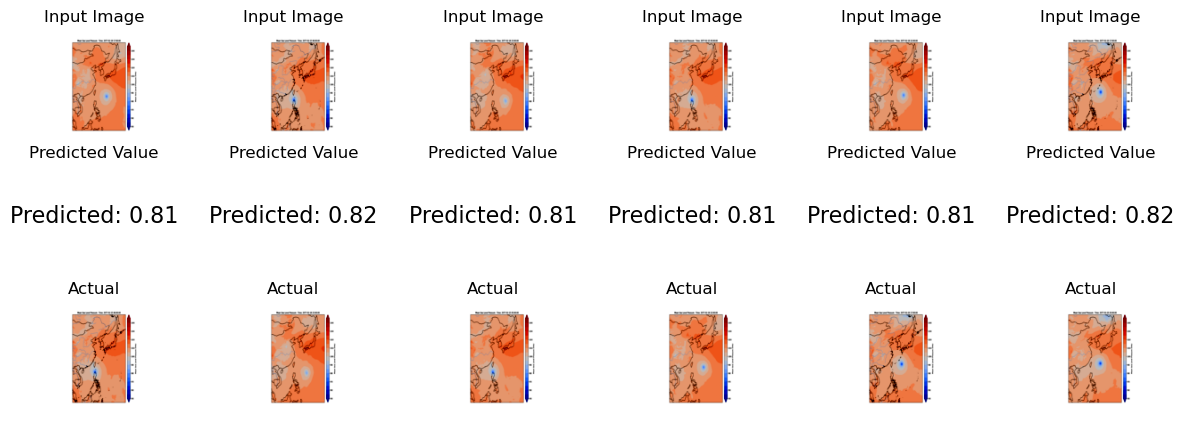

In [44]:
# Adjust the visualization function if keeping single scalar predictions
def visualize_predictions(model, dataloader, num_samples=6):
    model.eval()
    with torch.no_grad():
        for images, targets in dataloader:
            outputs = model(images)
            break  # Get only the first batch

    # Convert tensors to numpy arrays
    images = images.numpy()  # Shape: (batch_size, channels, height, width)
    predicted = outputs.numpy()  # Shape: (batch_size, output_size)
    actual = targets.numpy()  # Shape: (batch_size, channels, height, width)

    print(f'Input images shape: {images.shape}')  # Debug shape
    print(f'Predicted outputs shape: {predicted.shape}')  # Debug shape
    print(f'Actual targets shape: {actual.shape}')  # Debug shape

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        # Display input images
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(images[i].transpose(1, 2, 0))  # Change shape for plotting (C, H, W) to (H, W, C)
        plt.title('Input Image')
        plt.axis('off')

        # Display predicted values (as text or some visual representation)
        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.text(0.5, 0.5, f'Predicted: {predicted[i][0]:.2f}', fontsize=16, ha='center')
        plt.title('Predicted Value')
        plt.axis('off')

        # Display actual images
        plt.subplot(3, num_samples, i + 1 + num_samples * 2)
        plt.imshow(actual[i].transpose(1, 2, 0))  # Adjust if necessary (C, H, W) to (H, W, C)
        plt.title('Actual')
        plt.axis('off')

    plt.show()

# Call the visualization function
visualize_predictions(model, validation_dataloader)

In [43]:
from sklearn.metrics import mean_absolute_error, r2_score

# Collect predictions and actual targets
all_preds = []
all_targets = []
model.eval()
with torch.no_grad():
    for images, targets in validation_dataloader:
        outputs = model(images)
        all_preds.append(outputs.numpy())
        all_targets.append(targets.mean(dim=(1, 2, 3)).numpy())  # Using mean as target

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# Calculate metrics
mae = mean_absolute_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)
print(f'MAE: {mae}, R²: {r2}')


MAE: 0.0047291843220591545, R²: -0.18213367462158203
